In [1]:
import os
import sys
sys.path.insert(0, '..')
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import gym
import load_policy

%matplotlib inline

In [2]:
task = 'Walker2d-v1'
hidden_layer_num = 2
hidden_layer_size = 30
num_epochs = 30000
model_prefix = 'dagger-models/train-with-no-dagger-{0}-epochs/a'.format(num_epochs)
training_data_pkl = '../train_test_data/Walker2d-10-rollouts-200.pkl'

In [3]:
# TODO: this should be refactored and DRY from tuning-hyperparameters-and-visualization/train_humanoid.py

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


with open(training_data_pkl, 'rb') as inf:
    X_tv, y_tv, X_test, y_test = pickle.load(inf)

tf.logging.info('{0}, {1}, {2}, {3}'.format(
    X_tv.shape, X_test.shape, y_tv.shape, y_test.shape
))

x_plh = tf.placeholder(tf.float32, shape=[None, X_tv.shape[1]])
y_plh = tf.placeholder(tf.float32, shape=[None, y_tv.shape[1]])

with tf.name_scope('fc1'):
    Wh_var = weight_variable([x_plh.shape.dims[1].value, hidden_layer_size])
    bh_var = bias_variable([hidden_layer_size])
    hh = tf.nn.sigmoid(tf.matmul(x_plh, Wh_var) + bh_var)

for i in range(hidden_layer_num - 1):
    with tf.name_scope('fc{0}'.format(i + 2)):
        Wh_var = weight_variable([hidden_layer_size, hidden_layer_size])
        bh_var = bias_variable([hidden_layer_size])
        hh = tf.nn.sigmoid(tf.matmul(hh, Wh_var) + bh_var)

with tf.name_scope('out'):
    W_var = weight_variable([hidden_layer_size, y_plh.shape.dims[1].value])
    b_var = bias_variable([y_plh.shape.dims[1].value])
    y_pred = tf.matmul(hh, W_var) + b_var

INFO:tensorflow:(1608, 17), (402, 17), (1608, 6), (402, 6)


In [4]:
with tf.name_scope('mse'):
    mse = tf.losses.mean_squared_error(labels=y_plh, predictions=y_pred)
    mse = tf.cast(mse, tf.float32)

with tf.name_scope('adam_optimizer'):
    train_op = tf.train.AdamOptimizer(1e-4).minimize(mse)

In [5]:
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [6]:
mse_tv, mse_test = [], []

In [7]:
bs = 128      # batch size
for k in range(num_epochs): # num. epochs
    for i in range(X_tv.shape[0] // bs):
        _x = X_tv[i * bs : (i+1) * bs, :]
        _y = y_tv[i * bs : (i+1) * bs, :]
        train_op.run(feed_dict={x_plh: _x, y_plh: _y})

    if (k + 1) % 100 == 1:
        print(k, end=',')
    mse_tv.append(mse.eval(feed_dict={x_plh: X_tv, y_plh: y_tv}))
    mse_test.append(mse.eval(feed_dict={x_plh: X_test, y_plh: y_test}))

0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000,5100,5200,5300,5400,5500,5600,5700,5800,5900,6000,6100,6200,6300,6400,6500,6600,6700,6800,6900,7000,7100,7200,7300,7400,7500,7600,7700,7800,7900,8000,8100,8200,8300,8400,8500,8600,8700,8800,8900,9000,9100,9200,9300,9400,9500,9600,9700,9800,9900,10000,10100,10200,10300,10400,10500,10600,10700,10800,10900,11000,11100,11200,11300,11400,11500,11600,11700,11800,11900,12000,12100,12200,12300,12400,12500,12600,12700,12800,12900,13000,13100,13200,13300,13400,13500,13600,13700,13800,13900,14000,14100,14200,14300,14400,14500,14600,14700,14800,14900,15000,15100,15200,15300,15400,15500,15600,15700,15800,15900,16000,16100,16200,16300,16400,16500,16600,16700,16800,16900,17000,17100,17200,17300,17400,17500,17600,17700,17800,17900,18000,18100,18200,18300,18400,18

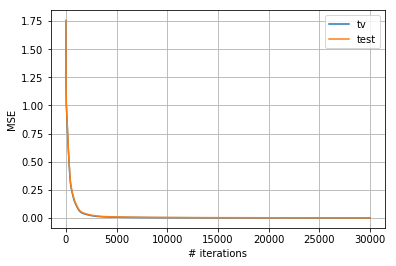

In [12]:
plt.plot(mse_tv, label='tv')
plt.plot(mse_test, label='test')
plt.legend()
plt.xlabel('# iterations')
plt.ylabel('MSE')
plt.grid()

In [13]:
print(mse_tv[-1], mse_test[-1])

0.00161509 0.00226328


In [14]:
saver.save(sess, model_prefix)

'dagger-models/train-with-no-dagger-30000-epochs/a'

In [15]:
out_df = pd.DataFrame(list(zip(mse_tv, mse_test)),
                      columns=['tv_mse', 'test_mse'])

out_df.to_csv(
    os.path.join(
        os.path.dirname(model_prefix), 'mse_train_test.csv'),
    index=False)